In [406]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from keras.utils.np_utils import to_categorical
import plotnine as p9
import matplotlib.pyplot as plt

In [407]:
credit = pd.read_excel('Default.xlsx')

In [408]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


In [409]:
credit.head(5)

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


In [410]:
#The first column is the row number in the excel sheet. Let's drop that column
credit = credit.drop(['Unnamed: 0'], axis=1)

In [411]:
#Lets check if any of the rows have NAs
credit[credit.isnull().sum(axis=1) > 0]

,default,student,balance,income


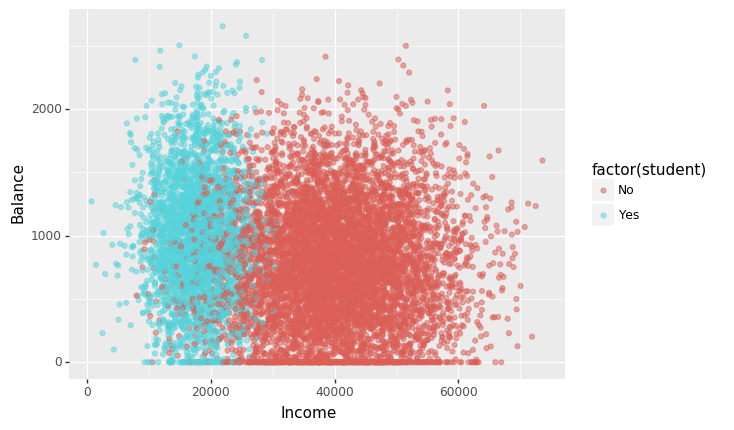

<ggplot: (8774920458729)>

In [412]:
(p9.ggplot(credit, p9.aes(x='income',y='balance', color='factor(student)')) 
   + p9.geom_point(alpha=0.5)
   + p9.labs(x='Income', y = 'Balance')     
)

As expected students have lower income than non-students. However, the balance is not that different among students and non-students

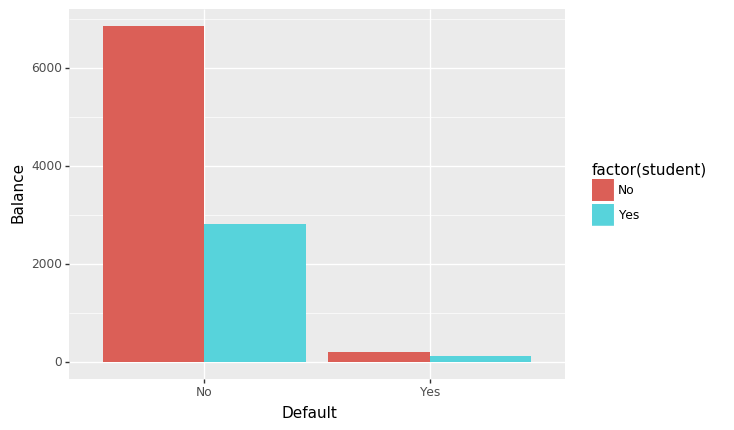

<ggplot: (8774920458741)>

In [413]:
(p9.ggplot(credit, p9.aes(x='factor(default)', fill='factor(student)')) 
   + p9.geom_bar(stat='count', position='dodge')
   + p9.labs(x='Default', y = 'Balance')     
)

We have a very percentage of defaulters in the dataset.

In [414]:
#Lets change the student & default data type to bool
yes_no_map = {'Yes': 1, 'No': 0}
credit.student = credit.student.map(yes_no_bool).astype('float32')
credit.default = credit.default.map(yes_no_bool).astype('float32')

Good! Nothing to worry about. 

In [415]:
credit.default.value_counts()/credit.shape[0]

0.0    0.9667
1.0    0.0333
Name: default, dtype: float64

Only 3.33% of the dataset represent non-defaulters. In cases like this where classes(default/no-default) are imbalanced an ROC curve is more appropriate than a confusion matrix. Let's try to build a model to predict if someone is going to default depending upon whether they are a student and their income and balance information

In [416]:
X = credit.drop(['default'], axis=1).values
y = credit['default'].values
#y = to_categorical(credit.default)

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [418]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
y_pred_prob = lgr.predict_proba(X_test)[:,1]
fpr_lgr, tpr_lgr, threshold_lgr= roc_curve(y_test, y_pred_prob)
roc_auc_lgr = auc(fpr_lgr, tpr_lgr)
print(roc_auc_lgr)

0.6003724137931035


#This score is only slightly better than random guessing. Lets try Random Forest

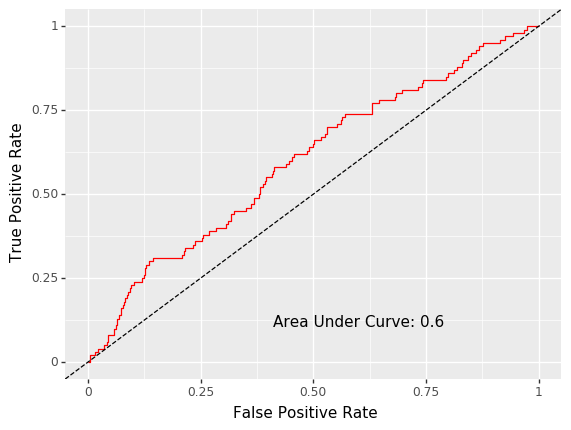

<ggplot: (8774914204837)>

In [419]:
data_lgr = pd.DataFrame({'fpr':fpr_lgr, 'tpr':tpr_lgr})
(p9.ggplot(data_lgr, p9.aes(x='fpr', y='tpr')) 
       + p9.geom_line(color='red') 
       + p9.geom_abline(linetype='dashed')
       + p9.labs(x='False Positive Rate', y='True Positive Rate')
       + p9.annotate("text", x=0.6, y=0.12, label = "Area Under Curve: "+str(round(roc_auc_lgr,2))))

In [420]:
from sklearn.ensemble import RandomForestClassifier

In [421]:
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=0.12, random_state=50)
rf.fit(X_train, y_train)
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_pred_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(roc_auc_rf)

0.8913362068965518


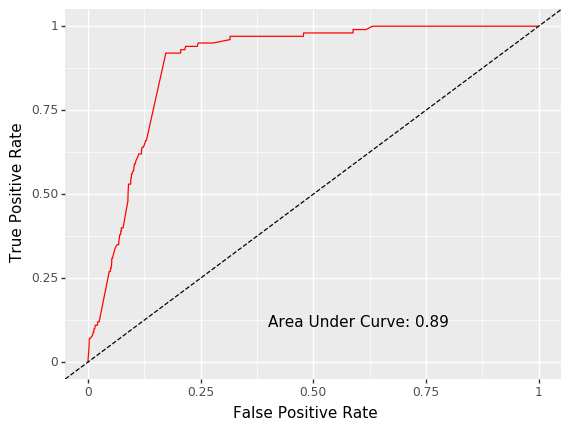

<ggplot: (8774913218329)>

In [422]:
#This score looks pretty good.
data_rf = pd.DataFrame({'fpr':fpr_rf, 'tpr':tpr_rf})
(p9.ggplot(data_rf, p9.aes(x='fpr', y='tpr')) 
       + p9.geom_line(color='red') 
       + p9.geom_abline(linetype='dashed')
       + p9.labs(x='False Positive Rate', y='True Positive Rate')
       + p9.annotate("text", x=0.6, y=0.12, label = "Area Under Curve: "+str(round(roc_auc_rf,2))))